In [1]:
#Adit Jindal
import pandas as pd
from datetime import datetime
import numpy as np
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import scipy.stats as st
from sklearn.linear_model import LinearRegression

In [2]:
np.set_printoptions(formatter = {'float_kind':'{:f}'.format}, suppress=True)
pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Retreiving Data

In [3]:
#Reading prices data
price_list = pd.read_csv("prices_S&P.csv")

In [4]:
price_list

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2022-01-03,156.48000000,18.75000000,236.78000000,182.01000000,135.42000000,132.62000000,139.04000000,44.55000000,407.21000000,...,87.77000000,67.94000000,63.54000000,56.89000000,116.89000000,136.53000000,129.13000000,583.90000000,64.24000000,234.03000000
1,2022-01-04,151.19000000,19.02000000,237.05000000,179.70000000,135.16000000,131.36000000,135.77000000,45.13000000,404.30000000,...,87.49000000,68.37000000,65.93000000,57.18000000,118.13000000,137.26000000,130.44000000,587.60000000,66.07000000,225.12000000
2,2022-01-05,148.60000000,18.68000000,236.45000000,174.92000000,135.87000000,132.50000000,135.16000000,44.60000000,397.18000000,...,84.25000000,69.04000000,66.75000000,56.26000000,116.52000000,135.52000000,130.01000000,558.18000000,66.22000000,216.56000000
3,2022-01-06,149.12000000,18.57000000,241.65000000,172.00000000,135.23000000,130.45000000,135.14000000,44.86000000,378.00000000,...,84.64000000,68.50000000,68.32000000,56.22000000,116.36000000,136.92000000,128.93000000,555.16000000,68.94000000,217.42000000
4,2022-01-07,145.15000000,19.28000000,238.09000000,172.17000000,134.88000000,133.12000000,135.56000000,45.07000000,370.75000000,...,84.55000000,69.10000000,68.88000000,56.40000000,115.43000000,135.35000000,128.15000000,530.86000000,70.09000000,211.09000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2022-12-23,149.23000000,12.71000000,143.28000000,131.86000000,163.10000000,170.01000000,108.18000000,63.38000000,266.09000000,...,80.72000000,70.93000000,108.68000000,31.83000000,109.73000000,128.90000000,126.69000000,248.22000000,48.45000000,145.76000000
247,2022-12-27,149.55000000,12.53000000,145.02000000,130.03000000,162.99000000,169.00000000,108.57000000,63.62000000,265.31000000,...,84.33000000,71.57000000,110.19000000,32.07000000,110.72000000,129.90000000,127.28000000,251.00000000,48.84000000,145.30000000
248,2022-12-28,148.09000000,12.32000000,145.30000000,126.04000000,162.23000000,167.36000000,107.83000000,62.60000000,263.12000000,...,80.09000000,70.57000000,108.38000000,30.98000000,108.94000000,129.31000000,125.99000000,246.84000000,47.97000000,143.83000000
249,2022-12-29,151.09000000,12.70000000,146.31000000,129.61000000,162.56000000,166.05000000,110.31000000,63.11000000,268.38000000,...,81.26000000,71.07000000,109.20000000,32.28000000,111.64000000,129.99000000,127.83000000,257.53000000,49.08000000,148.15000000


In [5]:
#230 is price for 1st December. So we have 230 data points to make predictions 
price_list.iloc[230]

Date     2022-12-01
A      156.12000000
AAL     13.98000000
AAP    151.30000000
AAPL   148.31000000
           ...     
YUM    129.19000000
ZBH    123.35000000
ZBRA   268.82000000
ZION    51.99000000
ZTS    156.64000000
Name: 230, Length: 505, dtype: object

#Euler method to find coefficents 

Equation: $g(t,y) = \sum_{i=0}^{M}{a_i}{t^i}y + b_0 + \sum_{j=1}^{N}{b_j}sin(\frac{2{\pi}j}{\theta}y + {c_j})$

Time series Data: $y_{0},y_{1},..,y_{n}$ at $t_{0},t_{1},..,t_{n}$ where n = 251 days 

Coefficients to estimate: $a_{0},a_{1},..,a_{M}, b_{0},b_{1},..,b_{N}, c_{1},c_{2},..,c_{N},{\theta}$

We need number of observations, n >= 2N + M + 4 to estimate 

In [6]:
#Train mdoel for a stock, M, and N

def train(stock, M, N):
  n = 2*N + M + 4
  Data_A = price_list[stock].to_list()

  #Use first n data points to form system of non-linear equations

  #Forward Euler Method; taking h = 1 (difference between stock price data is 1 day)

  delta_y = [Data_A[230-n + i] - Data_A[230-n + i-1] for i in range(1, n)]

  #Using fsolve which is based on Gauss-Newton method
  def equations(vars):
      A = vars
      eqs = []
      for i in range(n-1):
        e = 0
        for j in range(M+N+1):
          if j <= M:
            e += A[j]*((i**j)*Data_A[230-n + i - 1])
          elif j == M+1:
            e += A[j]
          else:
            e += A[j]*math.sin(((2*math.pi/A[n-2]) * Data_A[230-n + i - 1]) + A[j+N])
        e -= delta_y[i]
        eqs.append(e)
          
      return eqs

  coefficients =  fsolve(equations, [1/(n-1)]*(n-1))
  return n, Data_A, coefficients

In [7]:
#Using found coefficients to predict chosen stock's price at t = 230 (1st December 2022)
def predict_forward_Euler(M, N, n, Data_A, coefficients):
  y_n = Data_A[229]
  t = n

  #Forward Euler
  dy = 0
  for j in range(M+N+1):
    if j <= M:
      dy += coefficients[j]*((t**j)*Data_A[229])
    elif j == M+1:
      dy += coefficients[j]
    else:
      dy += coefficients[j]*math.sin(((2*math.pi/coefficients[n-2]) * Data_A[229]) + coefficients[j+N])

  y_predicted = y_n + 1*(dy)
  # print("Predicted stock price at t+1:" + str(y_predicted))
  # print("Actual stock price at t+1:" + str(Data_A[230]))
  return float(y_predicted)

In [8]:
#Function to Run Prediction Simulation
def run_predict(stock, M, N):
  n, Data_A, coefficients = train(stock, M, N)
  return predict_forward_Euler(M, N, n, Data_A, coefficients)

# Validation

From the possible coefficients based on different M and N values, we need to come to a single prediction. 


1.  First calculate the errors for each M, N prediction to the stock's real value on 12/2/2022. 
2.  Remove predictions whose values are greater than MAX_PERCENTAGE_DIFFERENCE from the stock's value on 11/30/2022.



In [9]:
#Calculate error - percentage difference
def validate(results, stock, MAX_PERCENTAGE_DIFFERENCE):
  errors = np.zeros((10,10))
  for i in range(len(results)):
    for j in range(len(results[0])):
      pred = results[i][j]
      actual = price_list.iloc[230][stock]
      errors[i][j] = abs(((actual- pred)*100 / actual))

  #Filter out values with difference from last price greater than 100% or stock price negative or 0
  for i in range(len(results)):
    for j in range(len(results[0])):
      pred = results[i][j]
      actual = price_list.iloc[229][stock]
      if pred <= 0 or abs(((actual- pred)*100 / actual)) > MAX_PERCENTAGE_DIFFERENCE:
        results[i][j] = -1
  return results, errors

##Graph showing increasing error with increasing M and N
We plot the graph for AAPL stock. From the graph, we notice error increasing with increasing M and N values. Hence, we decide to cap our results with 0 <= M, N <= 9

In [10]:
#Apple Stock Error Graph
results_apple = np.zeros((10,10))
for i in range(len(results_apple)):
  for j in range(len(results_apple[0])):
    results_apple[i][j] = run_predict("AAPL", i , j)
results_apple, errors_apple = validate(results_apple, "AAPL", 100)

/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [11]:
#Stock price results for Apple stock for 12/01/2022 with 0 <= M, N <= 9
pd.DataFrame(results_apple)

,0,1,2,3,4,5,6,7,8,9
0,147.91699046,148.05270102,145.14362786,164.80491101,161.80425980,146.74645592,152.96018461,150.69041516,148.29405809,154.83686573
1,157.80408267,149.46556239,148.93178925,148.34280537,156.58599213,148.28655273,148.58877732,166.94532053,160.16425418,-1.00000000
2,181.77717715,146.51995966,154.93034786,157.27820351,244.28642461,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
3,207.91563177,170.72502665,220.12213638,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
4,206.60681971,222.35593999,277.72699505,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
5,149.75875688,276.04148481,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
6,67.58178253,289.54823130,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
7,137.60105725,212.67087321,128.00379041,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
8,-1.00000000,3.28579979,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000
9,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000,-1.00000000


In [12]:
#Relative Errors for prediction of Apple stock for 12/01/2022 with 0 <= M, N <= 9
pd.DataFrame(errors_apple)

,0,1,2,3,4,5,6,7,8,9
0,0.26499194,0.17348727,2.13496874,11.12191424,9.09868505,1.05424049,3.13544913,1.60502674,0.01074905,4.40082647
1,6.40151215,0.77915339,0.41924971,0.02211946,5.58019832,0.01580964,0.18796933,12.56511397,7.99288934,108.51403308
2,22.56569156,1.20695863,4.46385804,6.04693110,64.71338724,122.99846838,112.27254539,152.92938969,171.58485384,150.64465501
3,40.18989399,15.11363134,48.42029289,2749.49048738,2453.23528464,3210.42678891,3942.05750974,4569.79076873,6764.92725888,6565.88472000
4,39.30740996,49.92646483,87.26113887,40559.32095428,39440.23995672,91985.57467715,104666.56969171,165853.50915771,176622.01797174,257878.48849037
5,0.97684369,86.12466105,126.64984970,564479.65891494,617.89643314,250474.97974817,4672566.35911191,11265163.10764042,4646265.00238267,10692682.88162228
6,54.43207975,95.23176542,584.41567945,28774496.60661684,58026524.54431240,852233.27989565,148658032.99931082,216283448.01091892,310785298.72608441,508912621.27480209
7,7.22064780,43.39617909,13.69173325,91050.27593947,14509394.88651081,4481761726.25346851,5527435171.11351109,5279590075.48667431,10407924745.44172859,43575307104.43599701
8,416.12836939,97.78450557,370.19053219,16727458.19669044,22635680.43702881,67747921397.47619629,153111140440.78363037,235913258124.13958740,315422031575.29278564,626652699250.34143066
9,1654.99776651,111.75880261,13527.85897839,188864062.59940323,384549169.54122996,203933099261.16165161,3888827873280.47656250,13292245553890.62304688,29628266998185.97656250,22100545349482.80468750


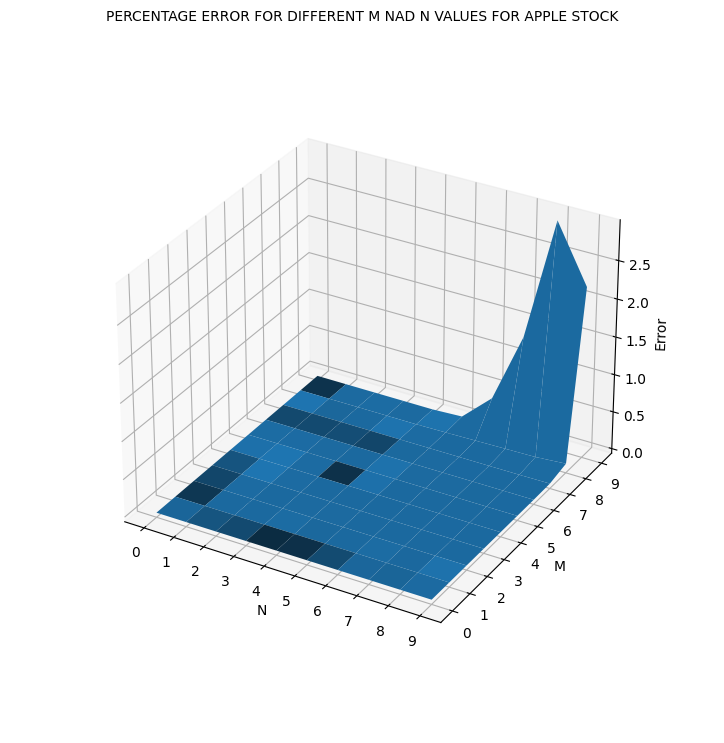

In [13]:
#Create Graph
def error_graph(errors):
  fig = plt.figure(figsize=(20,20))
  ax1 = fig.add_subplot(121, projection='3d')

  x = np.arange(10)
  y = np.arange(10)

  X, Y = np.meshgrid(x, y)
  a = ax1.plot_surface(X, Y, errors)

  ax1.set_xlabel('N')
  ax1.set_ylabel('M')
  ax1.set_zlabel('Error')
  ax1.set_zlim3d(bottom=0)
  plt.xticks(x)
  plt.yticks(y)
  ax1.set_box_aspect(aspect=None, zoom=0.8)
  font1 = {'color':'black','size':10}
  plt.title("PERCENTAGE ERROR FOR DIFFERENT M NAD N VALUES FOR APPLE STOCK", fontdict = font1)
  plt.show()

error_graph(errors_apple)

## Accuracy Metrics

As we note, the absolute error is increasing with M and N:
  Then, 

1.   We remove all predictions which have errors > MAX_PERCENTAGE_DIFFERENCE.
2.   We remove the outliers by setting OUTLIER_CONSTANT 
3.   Take the average of remaining predictions as the predicted price.
4.   The final error is calculated using this predicted price.
5.   Confidence Intervals are calculated with desired CONFIDENCE_LEVEL

In [14]:
def accuracy(predictions, stock, OUTLIER_CONSTANT=1.5):
  predictions = predictions.flatten()
  predictions_filtered = np.array(predictions != -1)
  predictions = predictions[predictions_filtered]
  predictions = removeOutliers(predictions, OUTLIER_CONSTANT)
  final_prediction = np.mean(predictions)
  actual = price_list.iloc[230][stock]
  error = abs((final_prediction - actual)*100/actual)
  return actual, final_prediction, error

def removeOutliers(lst, OUTLIER_CONSTANT=1.5):
  lower_quartile = np.percentile(lst, 25)
  upper_quartile = np.percentile(lst, 75)
  inter_quartile_range = (upper_quartile - lower_quartile) 
  lower_bound = lower_quartile - inter_quartile_range*OUTLIER_CONSTANT
  upper_bound = upper_quartile + inter_quartile_range*OUTLIER_CONSTANT
  lst_filtered = lst[(lower_bound <= lst) & (lst <= upper_bound)]
  return lst_filtered

def confidenceInterval(predictions, CONFIDENCE_LEVEL=0.95):
  predictions = predictions.flatten()
  predictions_filtered = np.array(predictions != -1)
  predictions = predictions[predictions_filtered]

  mean = np.mean(predictions)
  std = np.std(predictions)
  degree_of_freedom = len(predictions) - 1

  t = np.abs(st.t.ppf((1 - CONFIDENCE_LEVEL) / 2, degree_of_freedom))
  confidence_interval = round((mean - t * (std / np.sqrt(len(predictions)))), 2), round(mean + t * (std / np.sqrt(len(predictions))), 2)
  return confidence_interval


In [15]:
#Accuracy Metrics for Apple Stock
actual, final_prediction, error = accuracy(results_apple, "AAPL", 1.5)
confidence_interval = confidenceInterval(results_apple, 0.80)

print("APPLE STOCK:\n")
print("Actual Price: ", actual)
print("Final Predicted Price: ", round(final_prediction,2))
print("Relative Error: " + str(round(error,3)) + "%")
print("80% Confidence Interval for Price:", confidence_interval)

APPLE STOCK:

Actual Price:  148.31
Final Predicted Price:  162.58
Relative Error: 9.623%
80% Confidence Interval for Price: (156.48, 178.32)


# Run Simulation

Final method to run price prediction and accuracy simulation on all stocks of the S&P 500. Method stores results in a dictionary with key as stock, and actual price for 12/01/2022, predicted price for 12/01/2022, relative  error, and 80% confidence intervals for price as values.

In [71]:
final_outputs = {}
stock_list = price_list.columns[1:][:]

In [54]:
#For all stocks saves results tuple in final_outputs dictionary
def run_simulation(stock_list, MAX_PERCENTAGE_DIFFERENCE=100, OUTLIER_CONSTANT=1.5):
  for stock in stock_list:
    results = np.zeros((10,10))
    for i in range(len(results)):
      for j in range(len(results[0])):
        results[i][j] = run_predict(stock, i , j)
    results, errors = validate(results, stock, MAX_PERCENTAGE_DIFFERENCE)
    actual, final_prediction, error = accuracy(results, stock, OUTLIER_CONSTANT)
    confidence_interval = confidenceInterval(results, 0.80)
    final_outputs[stock] = (actual, final_prediction, error, confidence_interval)
run_simulation(price_list.columns[1:][:], 100, 1.5)

/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [55]:
#Save results in a pickle file
with open('results_euler.pkl', 'wb') as f:
  pickle.dump(final_outputs, f)
  print("saved values")

saved values


In [58]:
len(final_outputs)

504

In [83]:
#Load results from pickle file
with open('results_euler.pkl', 'rb') as f:
  results_Euler = pickle.load(f)
  print("success")
len(results_Euler)

success


504

## Visualize S&P 500: Real and Predicted values

1. The first graph shows the real vs predicted values for n stocks from the S&P 1500
2. The second graph shows the real vs predicted equally weigthed average price of the index, along with relative error

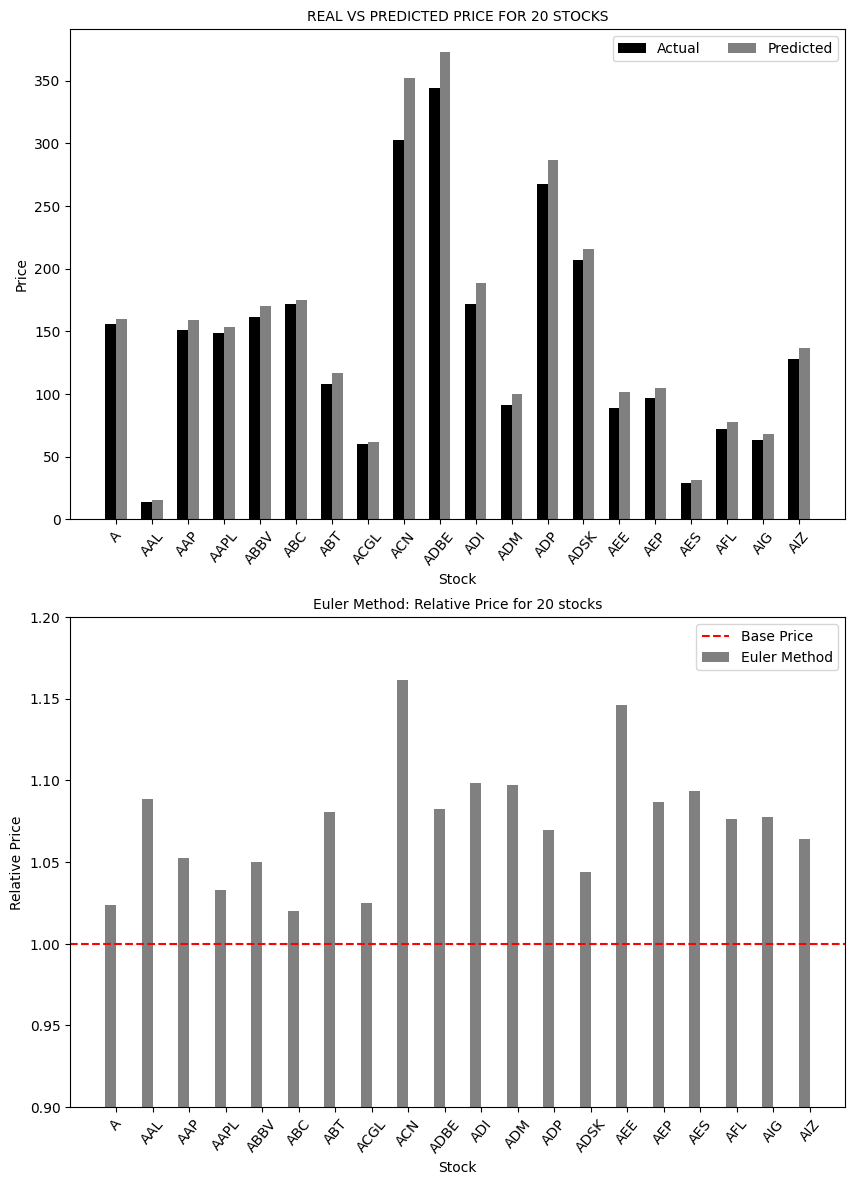

In [122]:
def stock_price_graph(results, n):

  ind = np.arange(n)
  x = np.array(list(results.keys())[:n])
  y_true = np.array([a[0] for a in list(results.values())[:n]])
  y_pred = np.array([a[1] for a in list(results.values())[:n]])

  fig, ax = plt.subplots(2, 1, figsize=(10, 14))
  ax[0].bar(ind, y_true, 0.3, color='black', label='Actual')
  ax[0].bar(ind+0.3, y_pred, 0.3, color='grey', label='Predicted')

  ax[0].set_xticks(ind + 0.3 / 2, x)

  ax[0].set_xlabel('Stock')
  ax[0].set_ylabel('Price')
  ax[0].legend(loc='upper right', ncols=2)
  plt.setp(ax[0].get_xticklabels(), rotation=50, horizontalalignment='center')
  plt.setp(ax[1].get_xticklabels(), rotation=50, horizontalalignment='center')
  font1 = {'color':'black','size':10}
  ax[0].set_title("REAL VS PREDICTED PRICE FOR 20 STOCKS", fontdict = font1)


  ax[1].set_xticks(ind + 0.3 / 2, x)
  ax[1].bar(ind, y_pred/y_true, 0.3, color='grey', label='Euler Method')
  ax[1].set_ylim(ymax = 1.2, ymin = 0.9) 
  ax[1].set_xlabel('Stock')
  ax[1].set_ylabel('Relative Price')
  ax[1].legend(loc='upper right', ncols=2)
  ax[1].axhline(1, color='red', label = "Base Price", linestyle='--')
  ax[1].legend(loc = 'upper right')
  ax[1].set_title("Euler Method: Relative Price for 20 stocks", fontdict = font1)

  plt.show()

stock_price_graph(results_Euler, 20)

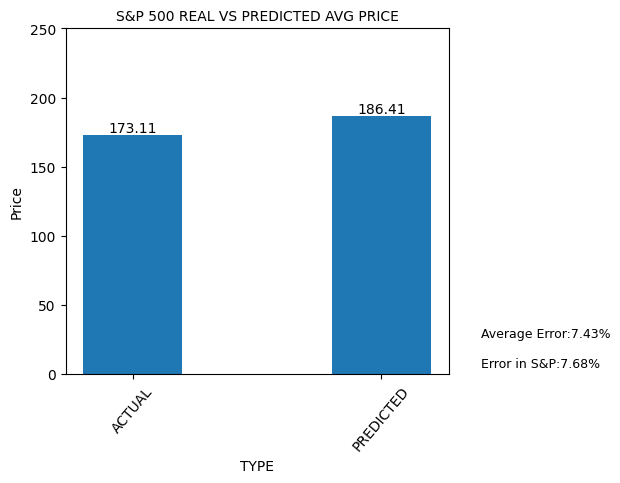

In [136]:
def average_price_graph(results_loaded):

  #Average S&P 500 Error
  errors = [a[2] for a in list(results_loaded.values())]
  y_true = [a[0] for a in list(results_loaded.values())]
  y_pred = [a[1] for a in list(results_loaded.values())]

  Error = round(np.mean(errors),2)
  SPReal = round(np.mean(y_true), 2)
  SPPredicted = round(np.mean(y_pred), 2)
  SPError = round(abs((SPReal-SPPredicted)*100/SPReal), 2)

  ind = np.arange(2)
  fig, ax = plt.subplots()
  plt.ylim(top=250)
  bars = ax.bar(ind, [SPReal, SPPredicted], width = 0.4)
  plt.xticks(ind, ["ACTUAL", "PREDICTED"])
  ax.bar_label(bars) 

  ax.set_xlabel('TYPE')
  ax.set_ylabel('Price')
  plt.text(1.4, 5, 'Average Error:%s'%(Error)+"%" + '\n\nError in S&P:%s'%(SPError)+"%", fontsize = 9)
  plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
  plt.tight_layout()

  font1 = {'color':'black','size':10}


  plt.title("S&P 500 REAL VS PREDICTED AVG PRICE", fontdict = font1)
  plt.show()

average_price_graph(results_Euler)

# Comparison with linear regression

## Choosing appropriate number of data points, n
Here, we compare the average error of our model to a baseline model based on linear regression using past n data points to predict stock prices on 12/1/2022.

1. First plot is between errors in prediction vs n
2. Second plot shows predicted prices for different n as well as the actual price for the stock

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


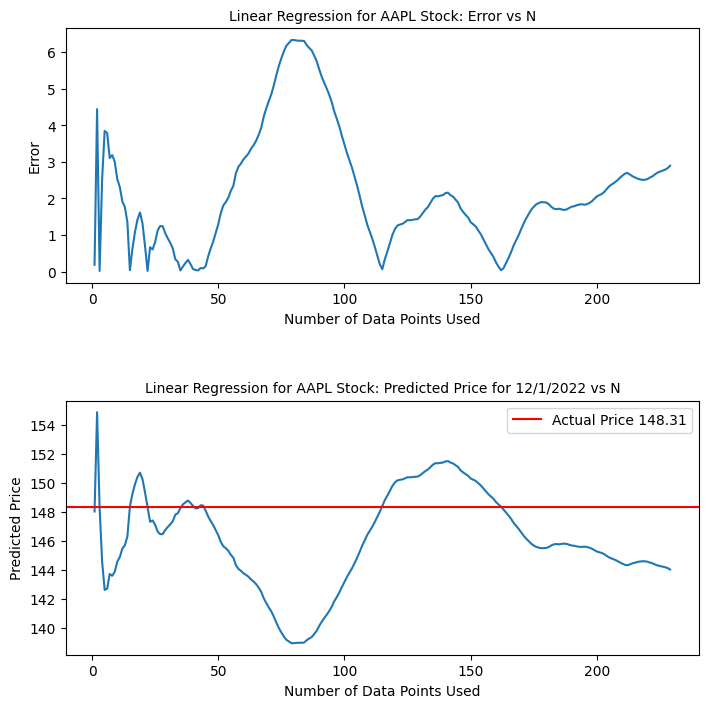

In [70]:
#Using Sklearn Linear Regression Model using past n data point 
def linearRegressionPredictor(stock, n):
  data = price_list[stock].to_list()
  X = np.arange(n).reshape(-1, 1)
  y = [data[230 - n + i] for i in range(n)]
  reg = LinearRegression().fit(X, y)
  score = reg.score(X, y)
  prediction = round(reg.predict(np.array([n]).reshape(-1, 1))[0], 2)
  actual = price_list[stock].to_list()[230]
  error = abs((prediction - actual)*100/actual)
  return prediction, error, score


def linearRegressionErrorGraph(stock):

  x = np.arange(1, 230)
  price_results = []
  error_results = []
  score_results = []
  for i in range(1, 230):
    prediction, error, score = linearRegressionPredictor(stock, i)
    price_results.append(prediction)
    error_results.append(error)
    score_results.append(score)


  real_price = price_list[stock].to_list()[230]
  fig, ax = plt.subplots(2, 1, figsize=(8, 8))
  ax[0].plot(x, error_results)
  ax[1].plot(x, price_results)


  ax[0].set_xlabel('Number of Data Points Used')
  ax[0].set_ylabel('Error')
  font1 = {'color':'black','size':10}
  ax[0].set_title("Linear Regression for %s" %(stock) + " Stock" + ": Error vs N", fontdict = font1)

  ax[1].set_xlabel('Number of Data Points Used')
  ax[1].set_ylabel('Predicted Price')
  font1 = {'color':'black','size':10}
  ax[1].set_title("Linear Regression for %s" %(stock) + " Stock:" + " Predicted Price for 12/1/2022 vs N", fontdict = font1)
  ax[1].axhline(real_price, 0, 230, color='red', label = "Actual Price %s" %(real_price))
  ax[1].legend(loc = 'upper right')

  fig.tight_layout(pad=4.0)
  plt.show()

  return price_results, error_results, score_results

price_results, error_results, score_results = linearRegressionErrorGraph("AAPL")

## Comparison Graphs

We notice that with greater number of data points, error is increasing due to overfitting. Thus, we decide to stick to n = 10 data points in line with Euler's method where we use 0 < M & N < 10.

1. We plot stock price graphs showing linear regression price and Euler's method predicted price. The scale is chosen as relative by dividing the price by the actual price of the stock.

2. We plot the price of an equally weighted S&P 500 portfolio and report the errors.


In [78]:
results_LR = {}
def linearRegressionResults(n):
  for stock in stock_list:
    results_LR[stock] = linearRegressionPredictor(stock, n)

linearRegressionResults(10)

In [80]:
#Save results in a pickle file
with open('results_LR.pkl', 'wb') as f:
  pickle.dump(results_LR, f)
  print("saved values")

saved values


In [82]:
#Load results from pickle file
with open('results_LR.pkl', 'rb') as f:
  results_LR = pickle.load(f)
  print("success")
len(results_LR)

success


504

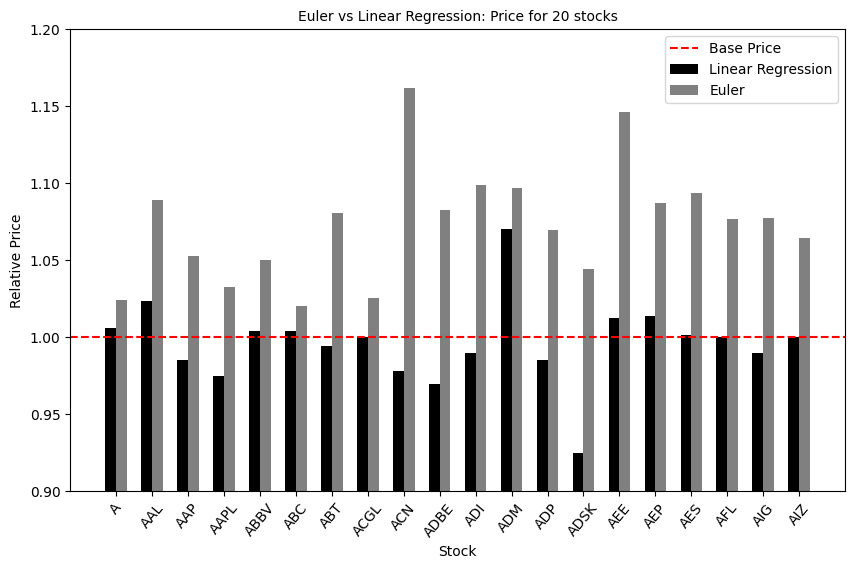

In [105]:
def stock_price_graph(results_Euler, results_LR, n):

  ind = np.arange(n)
  x = np.array(list(results_Euler.keys())[:n])
  y_true = np.array([a[0] for a in list(results_Euler.values())[:n]])
  y_pred_Euler = np.array([a[1] for a in list(results_Euler.values())[:n]]) / y_true
  y_pred_LR = np.array([a[0] for a in list(results_LR.values())[:n]]) / y_true

  y_true =  np.array([1 for i in range(n)])

  fig, ax = plt.subplots(figsize=(10, 6))
  # ax.bar(ind, y_true, 0.3, color='grey', label='Actual')
  ax.bar(ind, y_pred_LR, 0.3, color='black', label='Linear Regression')
  ax.bar(ind+0.3, y_pred_Euler, 0.3, color='grey', label='Euler')


  plt.ylim(ymax = 1.2, ymin = 0.9) 
  plt.xticks(ind + 0.3 / 2, x)

  ax.set_xlabel('Stock')
  ax.set_ylabel('Relative Price')
  ax.legend(loc='upper right', ncols=2)

  ax.axhline(1, color='red', label = "Base Price", linestyle='--')
  ax.legend(loc = 'upper right')

  plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')

  font1 = {'color':'black','size':10}
  plt.title("Euler vs Linear Regression: Relative Price for 20 stocks", fontdict = font1)

  plt.show()

stock_price_graph(results_Euler, results_LR, 20)

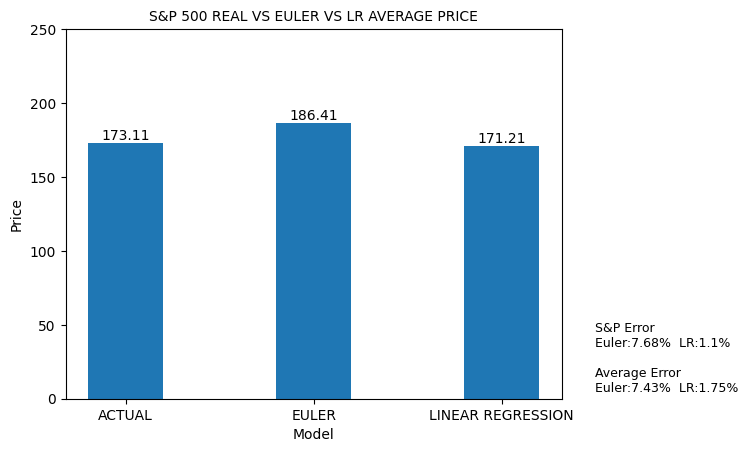

In [163]:
def average_price_graph(results_Euler, results_LR):

  #Average S&P 500 Error
  errors_euler = [a[2] for a in list(results_Euler.values())]
  y_true = [a[0] for a in list(results_Euler.values())]
  y_euler = [a[1] for a in list(results_Euler.values())]
  y_lr = [a[0] for a in list(results_LR.values())]
  errors_LR = [a[1] for a in list(results_LR.values())]

  Error_Euler = round(np.mean(errors_euler),2)
  Error_LR = round(np.mean(errors_LR),2)

  SPReal = round(np.mean(y_true), 2)
  SPEuler = round(np.mean(y_euler), 2)
  SPLR = round(np.mean(y_lr), 2)

  SPErrorEuler = round(abs((SPReal-SPEuler)*100/SPReal), 2)
  SPErrorLR = round(abs((SPReal-SPLR)*100/SPReal), 2)

  ind = np.arange(3)
  fig, ax = plt.subplots()
  plt.ylim(top=250)
  bars = ax.bar(ind, [SPReal, SPEuler, SPLR], width = 0.4)
  plt.xticks(ind, ["ACTUAL", "EULER", "LINEAR REGRESSION"])
  ax.bar_label(bars) 

  ax.set_xlabel('Model')
  ax.set_ylabel('Price')
  plt.text(2.5, 5, 'S&P Error\nEuler:%s'%(SPErrorEuler)+"%  " + 'LR:%s'%(SPErrorLR)+"%" + '\n\nAverage Error\nEuler:%s'%(Error_Euler)+"%  " + 'LR:%s'%(Error_LR)+"%", fontsize = 9)
  # plt.tight_layout()

  font1 = {'color':'black','size':10}


  plt.title("S&P 500 REAL VS EULER VS LR AVERAGE PRICE", fontdict = font1)
  plt.show()

average_price_graph(results_Euler, results_LR)